In [2]:
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import traceback
import math
import seaborn as sns
import copy
sns.set_style('dark')
np.random.seed(42)

# Classes

In [2]:
horas_aulas = ["7:30", "8:20", "9:10", "10:00", "10:50", "11:40", "13:00", "13:50", "14:40", "15:30", "16:20", "17:10", "18:00", "18:50", "19:40", "20:30", "21:30"]
dias_da_semana = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado"]

def zerar_horario(data=0):
    horas_aulas = ["7:30", "8:20", "9:10", "10:00", "10:50", "11:40", "13:00", "13:50", "14:40", "15:30", "16:20", "17:10", "18:00", "18:50", "19:40", "20:30", "21:30"]
    dias_da_semana = ["Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado"]
    horario_zerado = pd.DataFrame(index=horas_aulas, columns=dias_da_semana, data=data)
    return (horario_zerado)

class Periodo():
    def __init__(self,serie=2):
        self.serie = serie
        self.horario_periodo = zerar_horario()
        self.horario_periodo_nomes = zerar_horario(data = "")
        self.materias=[]
        self.pontuacao = 0
        self.pontuacao_maxima = self.calcula_pontuacao_maxima()
        
    def calcula_pontuacao_maxima(self):
        pont_maxima = 0
        for i in list(materias[materias["Serie"]==self.serie]["Créditos"]):
            if (i==15):
                pont_maxima += 4
            elif (i==1):
                pont_maxima += 2
            elif (i==5):
                pont_maxima += 6
            else:
                pont_maxima += i
                
                
#         if self.serie ==8:
#             pont_maxima = 26
                
        return pont_maxima      
    
    def __str__(self):
        return "Periodo: %s\nQuantidade de Materias: %s\n"%(self.serie, len(self.materias))
        
    def resetar_horarios_p(self):
        self.horario_periodo = zerar_horario()
        self.horario_periodo_nomes = zerar_horario(data = "")
            
    def add_materia_em_periodo(self, materia):
        horario_aula = [0]*17 # quantidade de horarios no dia
        dias = []        
        # Cria e testa horário. Primeiro caso, de 200 minutos semanais.
        atualizado = materia.horarios + self.horario_periodo
        
        if 2 in (atualizado.values):
            return False
        else:
            self.horario_periodo = atualizado
            self.horario_periodo_nomes = self.horario_periodo_nomes + materia.horarios.replace(1, materia.nome).replace(0,"") 
            self.materias.append(materia)
            return True

    def preenche_periodo(self, metodo='aleatorio', *args):
        global materias
        global professores
        verbose  = False # TEm que virar um parametro
        '''
        Função que cria um período com todas as suas disciplinas. Feito de forma aleatória. Tenativas são feitas
        até que todas as matérias estejam alocadas. Não aloca as matérias no período, a função "add_materia_em_periodo"
        é responsável por isso.
        
        Args é para receber matérias caso seja combinação.
        
        '''
        if metodo == 'aleatorio':
            professores = reiniciar_professores() # Isso aqui é um problema quando eu for gerar de vários períodos diferentes
            tentativas = 0
            lista_materias_atual = materias[materias["Serie"]==self.serie].values
            j = 0
            while j < len(lista_materias_atual):
                if verbose:
                    print (f'Materia N°{j}: {lista_materias_atual[j]}')
                    
                materia = Materia(nome=lista_materias_atual[j][2], professor= "", sala= "D6", vagas=45, serie=self.serie, carga_semanal=lista_materias_atual[j][4])
                materia.criar_horario()
                resultado_teste_adicao = self.add_materia_em_periodo(materia) #, periodo
                
                while resultado_teste_adicao == False:
                    materia.criar_horario()
                    resultado_teste_adicao = self.add_materia_em_periodo(materia)  #, periodo
                    tentativas += 1
                    if tentativas > 20:
                        self.horario_periodo = zerar_horario() # zera o período.
                        self.horario_periodo_nomes = zerar_horario(data = "") # zera o período.
                        self.materias = []
                        professores = reiniciar_professores()
                        tentativas = 0
                        j = 0 # Reinicia a criação do período
                        break
                        
                if resultado_teste_adicao == True:
                    materia.escolher_professor()
                    j+=1
            
        elif metodo == 'combinacao':
#             print ("To combinando")
            materias_combinadas = args[0]
            resultados = []
            for materia in materias_combinadas:
                resultados.append(self.add_materia_em_periodo(materia))
                
            # Se der algum erro nas adições de matérias no período, vai retornar um False
            if False in resultados:
                return False

class Materia(Periodo):
    def __init__(self,nome, professor,serie, sala, vagas, qntd_turmas=1, demanda=1, curso="Engenharia Mecânica", carga_semanal=60):
        Periodo.__init__(self, serie)
        self.nome = nome
        self.professor = professor
        self.sala = sala
        self.vagas = vagas
        self.horarios = zerar_horario()
        self.qntd_turmas = qntd_turmas
        self.demanda = demanda
        self.curso = curso
        self.carga_semanal = carga_semanal
    
    def __str__(self):
        return "Disciplina: %s\nProfessor: %s\nSala: %s\nVagas: %s\nCurso: %s\nCarga Total: %s horas\n"%(self.nome, self.professor, self.sala, self.vagas, self.curso, self.carga_semanal)

    def resetar_horarios(self):
        self.horarios = zerar_horario()
            
    def preencher_horarios(self, dias, blocos_hora):
        for dia in dias:
            self.horarios[dia] = blocos_hora
    
    def criar_horario(self):
        '''
        Cria horário para disciplina, conforme a sua carga horária e período. 
        '''
        matutino = (0,8)
        vespertino = (6,15)
        self.resetar_horarios()
        horario_aula = [0]*17 # quantidade de horarios no dia
        
        # Define o horário que terá aulas. Considerando que até o sexto só tem aula de manha
        if self.serie<7:
            turno = matutino
        else:
            turno = vespertino
        
        if self.carga_semanal == 90:
            dias_aulas = ["Segunda", "Quarta", "Sexta"]
            comeco_aula = random.randint(turno[0],turno[1]) # Escolhe o começo da aula, aleatoriamente
            if comeco_aula == 5:
                comeco_aula = comeco_aula +1 # Para evitar que comece no almoço
                
            horario_aula[comeco_aula] = 1
            horario_aula[comeco_aula + 1] = 1
            self.preencher_horarios(dias=dias_aulas, blocos_hora=horario_aula)
            
        elif self.carga_semanal == 30:
            primeiro_dia = random.choice(dias_da_semana[:2])
            dias_aulas = [primeiro_dia]
            comeco_aula = random.randint(turno[0],turno[1]) # Escolhe o começo da aula, aleatoriamente
            if comeco_aula == 5:
                comeco_aula = comeco_aula +1 # Para evitar que comece no almoço
                
            horario_aula[comeco_aula] = 1
            horario_aula[comeco_aula + 1] = 1
            self.preencher_horarios(dias=dias_aulas, blocos_hora=horario_aula) 
    
        elif self.carga_semanal == 45:
            primeiro_dia = random.choice(dias_da_semana[:2])
            dias_aulas = [primeiro_dia]
            comeco_aula = random.randint(turno[0],turno[1]) # Escolhe o começo da aula, aleatoriamente
            if comeco_aula in [4,5]: # Para evitar que comece no almoço ou antes.
                comeco_aula = comeco_aula +1 
                
            horario_aula[comeco_aula] = 1
            horario_aula[comeco_aula + 1] = 1
            horario_aula[comeco_aula + 2] = 1

            self.preencher_horarios(dias=dias_aulas, blocos_hora=horario_aula) 
            
        else:
#                     if self.carga_semanal == 60:
            primeiro_dia = random.choice(dias_da_semana[:2])
            segundo_dia = dias_da_semana[dias_da_semana.index(primeiro_dia)+2]
            dias_aulas = [primeiro_dia, segundo_dia]
            comeco_aula = random.randint(turno[0],turno[1]) # Escolhe o começo da aula, aleatoriamente
            if comeco_aula == 5:
                comeco_aula = comeco_aula +1 # Para evitar que comece no almoço
                
            horario_aula[comeco_aula] = 1
            horario_aula[comeco_aula + 1] = 1
            self.preencher_horarios(dias=dias_aulas, blocos_hora=horario_aula)
        
        
    def add_professor_em_horario(self, professor):
#         print (professor)
        indice = professores.index[professores["Nome"] == professor][0]
        atualizado = professores.loc[indice]["Horario"] + self.horarios
        self.professor= professor

        if 2 in (atualizado.values):
            return False
        else:
            professores.iat[indice, 3] = atualizado
            return True

    def escolher_professor(self):
        '''
        Escolhe um professor para adicionar na disciplina. É escolhido conforme os professores possíveis para essa 
        disciplina em questão. O seu horário é verificado, impedindo que alguém ocupado sejado alocado.
        '''
        professores_possiveis = []
        for i in professores.values:
            if self.nome in i[4][0]: # Isso é a lista de materias ministraveis do professor i[4][0]
                professores_possiveis.append(i[0])

        professor = random.choice(professores_possiveis)     
        resultado_teste_horario = self.add_professor_em_horario(professor)
        while resultado_teste_horario == False:
            professor = random.choice(professores_possiveis)     
            resultado_teste_horario = self.add_professor_em_horario(professor)


# Abrindo dados

In [3]:
materias = pd.read_csv("mecanica_materias.csv")
materias["Nome"] = materias["Nome"].str.strip("\t").str.strip()


def reiniciar_professores():
    professores = pd.read_csv("professores.csv")
    professores[["Pref_Horario", "Horario", "Disciplinas"]]  = ""
    # Aloca um horário vazio para todos os professores.
    for i in range(0,len(professores)):
        professores.iat[i,2] = zerar_horario()
        professores.iat[i,3] = zerar_horario()

    # Isso aqui é pra preencher os professores aletoriamente. Só por enquanto pra rodar.
    # Preenche a planilha de preferência de todos os professores com horários aleatórios. Isso não vai ser usado no final.
    possibilidades = [0.1,0.2,0.3,0.4,0.5] # O nível de satisfação do professor com o horário
    for j in range (0, len(professores)):
        b = np.random.choice(possibilidades, size=(17,6))
        for i in range(0,len(professores.iat[j,2].values)):
            professores.iat[j,2].values[i] = b[i]*10

    # Preenche disciplinas lecionaveis. Aleatórias
    possibilidades = materias["Nome"]
    for j in range (0, len(professores)):
        b = np.random.choice(possibilidades, size=(1,20)) # Quantidade de matérias q cada prof dá. Ta alto pq é aleatório e preciso garantir que funciona
    #     for i in range(0,len(professores.iat[j,2].values)):
        professores.iat[j,4] = b
        
#     professores= professores.set_index("Nome")

    # Só para experimentar o 8° horário com preferencias "reais"
    professores.iat[11,2] = pd.read_csv("./pref_profs/Gabriel.csv", index_col=0)
    professores.iat[19,2] = pd.read_csv("./pref_profs/Barreda.csv", index_col=0)
    professores.iat[20,2] = pd.read_csv("./pref_profs/Evangelista.csv", index_col=0)
    professores.iat[21,2] = pd.read_csv("./pref_profs/Kieling.csv", index_col=0)
    professores.iat[14,2] = pd.read_csv("./pref_profs/Ricardo.csv", index_col=0)

    return professores
        
professores = reiniciar_professores()

# Algoritmo Genético

In [5]:
def f_objetivo_materia(materia):
    professor = materia.professor
    matriz_professor = (professores[professores["Nome"]==professor].Pref_Horario.values)[0].values
    matriz_materia = materia.horarios.values
    matriz_resultante = matriz_professor * matriz_materia
    pontuacao = matriz_resultante.sum() # Soma dos pesos
    return pontuacao

def f_objetivo_periodo(periodo):
    pontuacao = 0
    for materia in periodo.materias:
        pontuacao = pontuacao + f_objetivo_materia(materia)
        
    return pontuacao

In [6]:
def mutacao(periodo):
    ''' 
        Muta um único período. Troca o horário entre duas matérias (se possível).
        
        Não precisa retornar esse período para dentro de outra variável, basta chamar a função.
        Ela já altera o período na memória mesmo.
    '''
    materias_periodo = list(range(len(periodo.materias)))
    tentativas = 0
    funcionou  = False
    while (funcionou == False):
        escolhidas = random.choices(materias_periodo, k=2)
        horario1 = periodo.materias[escolhidas[0]].horarios
        horario2 = periodo.materias[escolhidas[1]].horarios
        
        if (periodo.materias[escolhidas[0]].carga_semanal == periodo.materias[escolhidas[1]].carga_semanal):
            periodo.materias[escolhidas[0]].horarios, periodo.materias[escolhidas[1]].horarios = horario2, horario1
            funcionou = True
            return periodo

        tentativas += 1
        
        if tentativas >10:
            return periodo
        
    return periodo

In [7]:
def combina_periodo(periodo1, periodo2):
    ''' 
        Retorna um filho.
        
        Escolhe um conjunto aleatório de matérias do período. Tenta juntar esse conjunto de um período com o resto desse 
        conjunto, presente em outro periodo. Assim:
        
        -> Matérias existentes nesse período: {1,2,3,4,5,6,7,8}
        
        -> Seleção aleatória de um conjunto para um período:
        Período 1: {2,5,8,4}
        
        -> Seleciono as matérias faltantes a partir do segundo perídoo:
        Período 2: {1,3,6,7}
        
        -> Faço o teste para ver se é possível juntar esses dois conjuntos entre as matérias. Se não, seleciono novas matérias
        aleatoriamente, até que essa combinação funcione. Se isso não der certo X (limite de convergência) vezes, a tentativa
        de combinação é cancelada e o filho será simplesmente um dos períodos pais.
    
    '''
    filho = Periodo(serie = periodo1.serie)
    
    materias_periodo = list(range(len(periodo1.materias)))
    amostra = math.trunc(len(periodo1.materias)/(1.1))
    tentativas = 0
    funcionou  = False
#     print (f'periodo1: {periodo1}')
#     print (f'periodo2: {periodo2}')
    
    while (funcionou == False):
        # Primeiro crio os sets, para que eu possa fazer a subtração
        materias_periodo1 = (set(np.random.choice(materias_periodo, size=amostra, replace=False)))
        materias_periodo2 = set(materias_periodo) - materias_periodo1

        
        if tentativas >60:
            materias_periodo1, materias_periodo2 = materias_periodo2, materias_periodo1
            
#         print (materias_periodo1)
#         print (materias_periodo2)
            
        # Depois faço uma lista com os objetos "Materia"
#         print (periodo1.materias)
#         print (materias_periodo1)
        materias_periodo1 = [periodo1.materias[i] for i in list(materias_periodo1)]
    
#         print (periodo2.materias)
#         print (materias_periodo2)
        materias_periodo2 = [periodo2.materias[i] for i in list(materias_periodo2)]
        
        materias_totais = []
        materias_totais = materias_periodo1 + materias_periodo2        
        filho = Periodo(serie = periodo1.serie)
        
        if (filho.preenche_periodo('combinacao', materias_totais)) == False:
            filho = Periodo(serie = periodo1.serie)
            tentativas += 1
        
        else:
            funcionou = True
#             print ("consegui combinar")
            
        if tentativas > 80:            
            # Se não conseguir em X tentativas, devolve o primeiro pai mesmo
            return periodo1
        
    return filho

In [8]:
def gera_populacao(populacao,limite_populacional, verbose,n):
    '''
    Aplica a função de combinação e mutacao em uma população (lista) de períodos. Isso é aplicado n vezes.  
    O resultado é uma população já otimizada.
    
    Os melhores indivíduos de cada geração são salvos em uma lista, para plotagem.
    '''
#     print ("Rodei")
    geracoes = n
    casais_formados = (int(round(len(populacao)/2)))
    tamanho = len(populacao) - 1 # OK
    melhores_individuos = []
    window_comparacao = []
    window_melhor_individuo = []
    
    for i in range (0, geracoes): # Quantas geracoes serão realizadas. 
        atual = i+1
        
        # Casais formados em cada geracao. Metade do tamanho da população, já que são pares.
        for j in range (0, casais_formados):
            filho = combina_periodo(populacao[j], populacao[tamanho-j])
#             filho = mutacao(filho)
            mutacao(filho)
            filho.pontuacao = copy.deepcopy(f_objetivo_periodo(filho))
            populacao.append(copy.deepcopy(filho))

        # Isso é para garantir que o primeiro indivíduo permanece. É meio gambiarra, pq só ele tava sendo deletado e não sei pq.
        if len(melhores_individuos)>0:
            pontuacoes = [x.pontuacao for x in populacao]
            if max(pontuacoes) < melhores_individuos[-1].pontuacao:
                populacao.append(copy.deepcopy(melhores_individuos[-1]))
            
        # Ordenada a população, para o próximo ciclo.
        populacao = sorted(populacao, key=lambda x: x.pontuacao, reverse=True)
        window_comparacao.append(copy.deepcopy(populacao))
        window_melhor_individuo.append(copy.deepcopy(populacao[0].pontuacao))
        
        
        # Deletar os extras acima do limite populacional
        populacao = [elem for elem in populacao if populacao.index(elem)<(limite_populacional)]
        melhores_individuos.append(copy.deepcopy(populacao[0]))
        
        # Mantem o window de comparacao com tamanho 5
        window_comparacao = [elem for elem in window_comparacao if window_comparacao.index(elem)<(5)] 
        
        # Mantem o window de comparação do melhor indivíduo com tamanho 30
        window_melhor_individuo = sorted(window_melhor_individuo, reverse=True)
        
#         window_melhor_individuo = [elem for elem in window_melhor_individuo if window_melhor_individuo.index(elem)<(30)] 
#         print (window_melhor_individuo)
        
        if (len(window_comparacao) >= 5):
            if (window_comparacao.count(window_comparacao[0])== 5):
                i = geracoes
                print ("Otimização ficou presa. Gerações indênticas por 5 iterações.")
                return (populacao, melhores_individuos)
            
        if (len(window_melhor_individuo) >= 30):
            del window_melhor_individuo[-1]
            qntd_unicos = len(set(window_melhor_individuo))
            print (f'Quantidade de indivíduos únicos: {qntd_unicos}')
            if (qntd_unicos== 1):
                print ("Otimização ficou presa. Melhor indivíduo imutável por 30 iterações.")
                return (populacao, melhores_individuos)
            
        print (f'Últimos melhores indivíduos: {window_melhor_individuo}')
        
        if len(set([x.pontuacao for x in populacao]))==1:
            print ("População estacou, somente mesmo indivíduo.")
            return (populacao, melhores_individuos)
        
#         melhores_individuos.append(copy.deepcopy(populacao[0]))
#         print ([x.pontuacao for x in melhores_individuos])
        
#         print ("Rodei tbm")
        
        pontuacao_maxima = populacao[0].pontuacao_maxima*5
        if ((window_melhor_individuo[0])==(pontuacao_maxima)):
            print ("Limite de pontuação atingido.")
            return (populacao, melhores_individuos)
    
        if verbose == True:
            print (f'Geração {atual}/{geracoes} finalizada.')
            print (f'Pontuação máxima possível: {pontuacao_maxima}')
            print (f'Top 5 Pontuações: {[x.pontuacao for x in populacao][:5]}')
            print (f'Top 5 "Satisfação Relativa Total": {[round(x.pontuacao/pontuacao_maxima, 2) for x in populacao][:5]}')
            print ("\n")
        
    return (populacao, melhores_individuos)

In [9]:
def genetico(n, serie, verbose):
    '''
    Função que une todas as etapas do algoritmo genético. Faz n ciclos de otimização de um dado período.
    
    Começa desde a criação da população inicial aleatória.
    '''
    
    global professores
    
#     professores = reiniciar_professores()
    limite_populacional = 30
    
    populacao = []
    
    # Criação da população inicial aleatória e cálculo da sua função objetivo
    
    if verbose:
        print ("Início da criação da população inicial.\n")
    
    inicio = time.time()
    for i in range (0, limite_populacional):
        professores = reiniciar_professores()
        periodo = Periodo(serie=serie)
        periodo.preenche_periodo()
        periodo.pontuacao = f_objetivo_periodo(periodo)
        populacao.append(copy.deepcopy(periodo))
    final = time.time()
    
    if verbose:
        print (f'População inicial criada. Tempo total: {round(final-inicio, 2)} segundos.\n')

    # Ordenada a populacao em ordem de pontuacao
    populacao = sorted(populacao, key=lambda x: x.pontuacao, reverse=True)
    
#     print ("Soteei")
    # Combinação e mutacao dos indivíduos, gerando os filhos
    return gera_populacao(populacao,limite_populacional, verbose,n)

In [10]:
def otimiza_um(periodo,n):
    '''
    Roda a função completa de otimização em um período.
    
    '''
    periodos_otimizados = [periodo]
    todas_as_populacoes = dict.fromkeys(periodos_otimizados)

    for i in periodos_otimizados:
        while True:
            try:
                populacao, melhores = genetico(n=n, serie=i, verbose=True)
                break
            except Exception as e:
                traceback.print_exc()
                print(e)           

        todas_as_populacoes[i] = populacao
        print (f"Periodo {i} otimizado.")
        
    return todas_as_populacoes

In [11]:
def otimiza_todos(n):
    '''
    Roda a função completa de otimização em todos os períodos.
    
    '''
    periodos_otimizados = [2,4,6,8,10]
#     periodos_otimizados = [4,6,8,10]
    todas_as_populacoes = dict.fromkeys(periodos_otimizados)

    for i in periodos_otimizados:
#         populacao, melhores = main(serie=i,n=100)
        while True:
            try:
                populacao, melhores = genetico(n=n, serie=i, verbose=True)
                break
#                 return 0#(populacao, melhores)
            except Exception as e:
                traceback.print_exc()
                print(e)           

        todas_as_populacoes[i] = populacao
        print (f"Periodo {i} otimizado.")
        
    return todas_as_populacoes

In [12]:
def visualizacao(melhores):
    plt.figure(figsize=(8,8))
    pontuacao = [x.pontuacao for x in melhores]
    plt.plot(pontuacao, marker='o')
    plt.xlabel('Geração', fontsize=15)
    plt.ylabel('Pontuação', fontsize=15)
    mplcyberpunk.add_glow_effects()

    plt.show()

In [13]:
def define_grade_para_professores(periodo):
    '''
    Recebe um período como parâmetro e ocupa os professores com esses horários. 
    '''
    profs = reiniciar_professores()
    profs = profs.set_index("Nome")
    
    lista_materias = periodo.materias
    for m in lista_materias:
        professor = m.professor
        horario = m.horarios

        # Ocupa o horário equivalente a matéria para esse professor
        horario_prof = copy.deepcopy(profs.loc[professor]["Horario"])
        index_prof = np.where(profs.index==professor)[0][0]
        
        profs.iat[index_prof, 2] = horario_prof + horario        
    return profs

In [14]:
def compara_professores(periodo, profs):
    '''
    Ve se um período pode ser incluído na planilha de professores. Retorna True se não for conflitante.
    '''
    materias_list = periodo.materias
    for m in materias_list:
        professor = m.professor
        horario = m.horarios
        
        if 2 in (profs.loc[professor]["Horario"] + horario).values:
            return False
    
    return True

In [105]:
def calc_satisfacao_relativa(profs):
    '''
    A partir da grade de professores, retorna uma lista com a satifação relativa de cada professor, sem o identificar.
    
    A satisfação relativa é a satisfação obtida / máxima satisfação possível. A máxima satisfação possível é a soma
    de todos os horários que o professor possui pelo peso máximo, que é 5. Isso é importante porque nem todos os 
    professores possuem a mesma quantidade de matérias, então não poderia ser algo absoluto.
    '''

    pontuacoes_relativas = []
    for i in range(0, len(profs)):
        matriz_preferencia = copy.deepcopy(profs.iat[i,1].values)
        matriz_horarios = copy.deepcopy(profs.iat[i,2].values)
        matriz_resultante = copy.deepcopy(matriz_preferencia * matriz_horarios)
        pontuacao = matriz_resultante.sum()
        
        pontuacao_total_possivel = matriz_horarios.sum().sum()*5
#         print (pontuacao)
#         print (pontuacao_total_possivel)
        if pontuacao != 0:
            pontuacao_relativa = pontuacao/pontuacao_total_possivel

            pontuacoes_relativas.append(pontuacao_relativa)
            
    
    return pontuacoes_relativas
    

# Exemplo de testes das funções

In [4]:
periodo = Periodo()

In [5]:
periodo.preenche_periodo()

In [ ]:
perioda["Terça"]

In [6]:
periodo.horario_periodo_nomes

,Segunda,Terça,Quarta,Quinta,Sexta,Sábado
7:30,Introdução à Economia,Linguagem de Programação II,,Linguagem de Programação II,,
8:20,Introdução à Economia,Linguagem de Programação II,,Linguagem de Programação II,,
9:10,Introdução à Economia,Cálculo II,,Cálculo II,,
10:00,Desenho Básico,Cálculo II,,Cálculo II,,
10:50,Desenho Básico,,,,,
11:40,Desenho Básico,Introdução à Administração,,,,
13:00,Probabilidade e Estatística,Introdução à Administração,Probabilidade e Estatística,,,
13:50,Probabilidade e Estatística,Introdução à Administração,Probabilidade e Estatística,,,
14:40,Física II,Álgebra Linear II,Física II,Álgebra Linear II,,
15:30,Física II,Álgebra Linear II,Física II,Álgebra Linear II,,


# Exemplo Algorítmo genético

In [ ]:
possiveis = [2,4,6,8,10]
# possiveis= [8]
periodos_escolhidos = []
# dict_final  = otimiza_um(8,500)
dict_final = otimiza_todos(500)
print ("Otimizei")

In [106]:
# Faz a montagem dos horários juntos
possiveis = [2,4,6,8,10]
profs = reiniciar_professores()
for i in range(0,len(possiveis)):
    escolhido = np.random.choice(possiveis)
    possiveis.remove(escolhido)
    if i == 0:
        profs = define_grade_para_professores(dict_final[escolhido][0])
        
    else:
        for i in dict_final[escolhido]:
            if compara_professores(i, profs):
                    lista_materias = i.materias
                    for m in lista_materias:
                        professor = m.professor
                        horario = m.horarios

                        # Ocupa o horário equivalente a matéria para esse professor
                        horario_prof = copy.deepcopy(profs.loc[professor]["Horario"])
                        index_prof = np.where(profs.index==professor)[0][0]

                        profs.iat[index_prof, 2] = horario_prof + horario
                        
                    break
                        
            else:
                pass
                
    periodos_escolhidos.append(dict_final[escolhido][0]) # Pega a melhor solução de período de cada período

In [107]:
ponts =  calc_satisfacao_relativa(profs)

<AxesSubplot:>

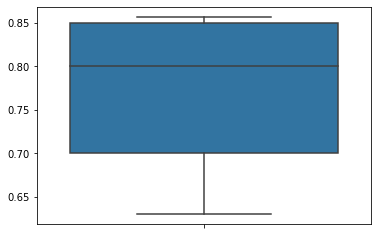

In [109]:
sns.boxplot(y=ponts)

In [19]:
def salvar_resultados(dict_completo, nome="./ciclos_importantes/dict_completo2.pkl"):
    with open(nome, 'rb') as file:
        dict_completo = pickle.load(file)

In [20]:
def plotar_um_pickle(x="./ciclos_importantes/dict_completo.pkl"):
    with open(x, 'rb') as file:
        dict_completo = pickle.load(file)

    periodos_escolhidos = []
    possiveis=[2,4,6,8,10]
    for i in range(0,len(possiveis)):
        escolhido = np.random.choice(possiveis)
        possiveis.remove(escolhido)
        if i == 0:
            profs = define_grade_para_professores(dict_final[escolhido][0])

        else:
            for i in dict_final[escolhido]:
                if compara_professores(i, profs):
                        lista_materias = i.materias
                        for m in lista_materias:
                            professor = m.professor
                            horario = m.horarios

                            # Ocupa o horário equivalente a matéria para esse professor
                            horario_prof = copy.deepcopy(profs.loc[professor]["Horario"])
                            index_prof = np.where(profs.index==professor)[0][0]

                            profs.iat[index_prof, 2] = horario_prof + horario

                        break

                else:
                    pass

        periodos_escolhidos.append(dict_final[escolhido][0])